In [1]:
import torch
from torch import nn
from pylightcurve_torch import TransitModule

# Losses

In [7]:
def reduce(x, reduction='mean', axis=None):
    if axis is None:
        axis = tuple(range(len(torch.ones(5,5).shape) - 1))
    if reduction == "mean":
        return x.mean(axis=axis)
    elif reduction == "sum":
        return x.sum(axis=axis)
    elif reduction == 'none':
        return x
    else:
        raise RuntimeError('wrong reduction argument')

def reduce_(x, reduction='mean', axis=None):
    if axis is None:
        axis = tuple(range(len(torch.ones(5,5).shape) - 1))    
    if reduction == "mean":
        return x.mean_(axis=axis)
    elif reduction == "sum":
        return x.sum_(axis=axis)
    elif reduction == 'none':
        return x
    else:
        raise RuntimeError('wrong reduction argument')
        
class MSETransitLoss(nn.Module):
    def __init__(self, transit_model, restrict_transit=False, batch_reduction='mean'):
        super().__init__()
        self.transit_model = transit_model
        self.restrict_transit = bool(restrict_transit)
        self.batch_reduction = batch_reduction
        
    def __call__(self, y, **pars):
        """ 
        X: input flux
        pred: dict of predictions
        phi: additional data
        
        """
        recons = self.transit_model(**pars)
        assert not torch.isnan(recons).any()
        
        if self.restrict_transit:
            durations = tm.get_duration(**pars)
            in_transit = torch.abs(tm.time - tm.mid_time) < durations  / 2
            recons_loss = nn.MSELoss(reduction='none')(recons * in_transit, y * in_transit)
            recons_loss = recons_loss.sum(-1, keepdim=True) / in_transit.sum(-1, keepdim=True)
            recons_loss = reduce(recons_loss, self.batch_reduction)
        else:
            recons_loss = nn.MSELoss(reduction="none")(recons, y)
            recons_loss = reduce(recons_loss, self.batch_reduction)
        return recons_loss
    
class RMSELoss(nn.Module):
    def __init__(self, batch_reduction = 'mean', time_reduction='mean'):
        super().__init__()
        self.batch_reduction = batch_reduction
        self.time_reduction = time_reduction
        
    def __call__(self, x, y):
        loss = nn.MSELoss(reduction='none')(x,y)
        loss = reduce(loss, self.time_reduction, -1)
        loss.sqrt_()
        return reduce(loss, self.batch_reduction)

    
class RMSETransitLoss(nn.Module):
    def __init__(self, transit_model, restrict_transit=False, batch_reduction="mean"):
        super().__init__()
        self.transit_model = transit_model
        self.restrict_transit = bool(restrict_transit)
        self.batch_reduction = batch_reduction
        #self.time_reduction = time_reduction
        
    def __call__(self, y, **pars):
        """ 
        X: input flux
        pred: dict of predictions
        phi: additional data
        
        """
        recons = self.transit_model(**pars)
        assert not torch.isnan(recons).any()
        
        if self.restrict_transit:
            durations = tm.get_duration(**pars)
            in_transit = torch.abs(tm.time - tm.mid_time) < durations  / 2
            recons_loss = nn.MSELoss(reduction='none')(recons * in_transit, y * in_transit)
            
            recons_loss = recons_loss.sum(-1, keepdim=True) / in_transit.sum(-1, keepdim=True)
            recons_loss.sqrt_()
            recons_loss = reduce(recons_loss, self.batch_reduction)
        else:
            recons_loss = RMSELoss(batch_reduction=self.batch_reduction)(recons, y)
        return recons_loss

In [25]:
x = torch.rand(1,10).float()
y = torch.rand(3,10).float()

#nn.MSELoss(reduction='none')(x,y).mean(1).mean(0).sqrt(), nn.MSELoss(reduction='none')(x,y).mean(1).sqrt().mean(0)


(nn.MSELoss(reduction="none")(x, y)).shape, (RMSELoss(batch_reduction='none', time_reduction="none")(x, y)**2).shape

torch.Size([3, 10])


(torch.Size([3, 10]), torch.Size([3, 10]))

In [32]:
time =  torch.linspace(4,6,1000)
pars =  {'e':0.01, 'i':90., 'w':0., 'rp': 0.02, 'method': 'linear', 'ldc': [0.2], 
             'P': 5., 't0': 5., 'a': 3., 'fp': 0.0001}
tm = TransitModule(time, **pars)
mse_loss = MSETransitLoss(tm, restrict_transit=False)
rmse_loss = RMSETransitLoss(tm, restrict_transit=False)

In [33]:
obs = tm() + torch.randn_like(tm())/100000
obs.shape, tm.shape

(torch.Size([1, 1000]), (1, 1000))

In [35]:

mse_loss(obs, rp=range(10), batch_reduction='none').shape

torch.Size([1000])

In [456]:
mse_loss(obs, rp=rp)

tensor([1.6973e-05], dtype=torch.float64)

In [457]:
MSETransitLoss(tm, restrict_transit=False, batch_reduction='none')(obs, rp=rp).shape

torch.Size([100, 1000])

ValueError: x and y must have same first dimension, but have shapes torch.Size([100]) and torch.Size([1])

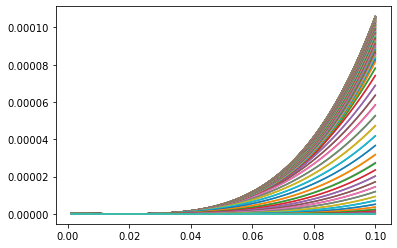

In [458]:
mse_errs = []
rmse_errs = []

rp = torch.linspace(0.001, 0.1, 100)
    
plt.plot(rp, MSETransitLoss(tm, restrict_transit=False, batch_reduction='none')(obs, rp=rp))
plt.plot(rp, rmse_loss(obs, rp=rp))
plt.yscale('log')

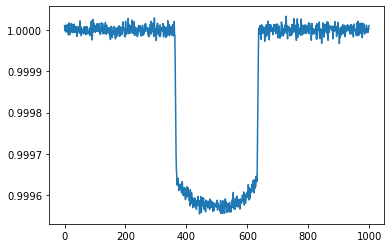

In [459]:
import matplotlib.pylab as plt
plt.plot(obs.T)



In [ ]:
# Hybrid module

In [221]:
TransitModule()

transit_pars = {'e':0.01, 'i':90., 'w':0., 'rp': 0.05, 'method': 'linear', 'ldc': [0.1], 
                'P': 4., 't0': 5., 'a': 5., 'fp': 0.0001}

class HybridModule(nn.Module):
    def __init__(self, time, theta_names = [], **transit_pars):
        """
        theta: ordered list of named parameters to predict and give as input to the transit model
        """
        super().__init__()
        self.theta_names = theta_names
        self.tm = TransitModule(time)
        self.tm.set_param(**transit_pars)
        self.tm.fit_param(*theta_names)
        self.lin = nn.Linear(self.tm.shape[-1], len(theta_names))
        
        
    def forward(self, flux):
        theta = self.lin(flux)
        return self.tm({theta[:,i]: theta_names[i] for i in range(len(self.theta_names))})
        

In [56]:
hm = HybridModule(torch.linspace(4, 7, 100), ['rp', 'e'], **transit_pars)
hm

HybridModule(
  (tm): TransitModule(primary, shape=(1, 100))
  (lin): Linear(in_features=100, out_features=2, bias=True)
)

In [57]:
hm.tm(w=2)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 0.9976, 0.9975, 0.9974, 0.9974, 0.9974, 0.9974, 0.9974,
         0.9975, 0.9976, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]], dtype=torch.float64, grad_fn=<MulBackward0>)